Import Libraries

In [22]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")

Import the Data

In [25]:
# Load the macrodata dataset from statsmodels
data = sm.datasets.macrodata.load_pandas().data

In [27]:
# Create a datetime index based on quarters
data['date'] = pd.date_range(start='1959-01-01', periods=len(data), freq='Q')
data.set_index('date', inplace=True)

In [29]:
# Keep only the unemployment column for time series analysis
ts_data = data[['unemp']]

In [31]:
# Preview data
ts_data.head()

,unemp
date,
1959-03-31,5.8
1959-06-30,5.1
1959-09-30,5.3
1959-12-31,5.6
1960-03-31,5.2


Subset the Data

In [34]:
# Reset index to access 'date' as a column
ts_data_reset = ts_data.reset_index()

In [36]:
# Subset from 1980 to 2008
ts_data_sub = ts_data_reset.loc[(ts_data_reset['date'] >= '1980-01-01') & (ts_data_reset['date'] <= '2008-12-31')]

In [38]:
# Set 'date' back as index
ts_data_sub.set_index('date', inplace=True)

In [40]:
# Preview result
ts_data_sub.head()

,unemp
date,
1980-03-31,6.3
1980-06-30,7.3
1980-09-30,7.7
1980-12-31,7.4
1981-03-31,7.4


Line Chart

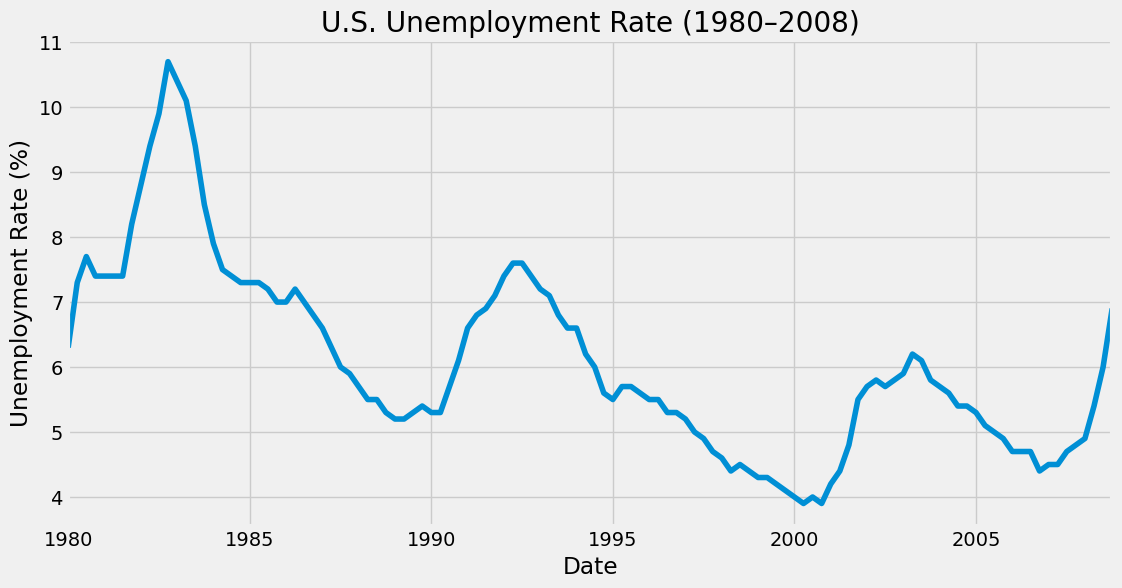

In [43]:
# Plot the unemployment rate over time
ts_data_sub.plot(figsize=(12, 6), title='U.S. Unemployment Rate (1980–2008)', legend=False)
plt.ylabel('Unemployment Rate (%)')
plt.xlabel('Date')
plt.grid(True)
plt.show()

Line Chart of the Unemployment Rate (1980–2008)
A line chart is a useful tool for visualizing how the unemployment rate changes over time. This chart helps reveal overall trends, potential seasonality, and any visible cycles in the data between 1980 and 2008.

Decomposition

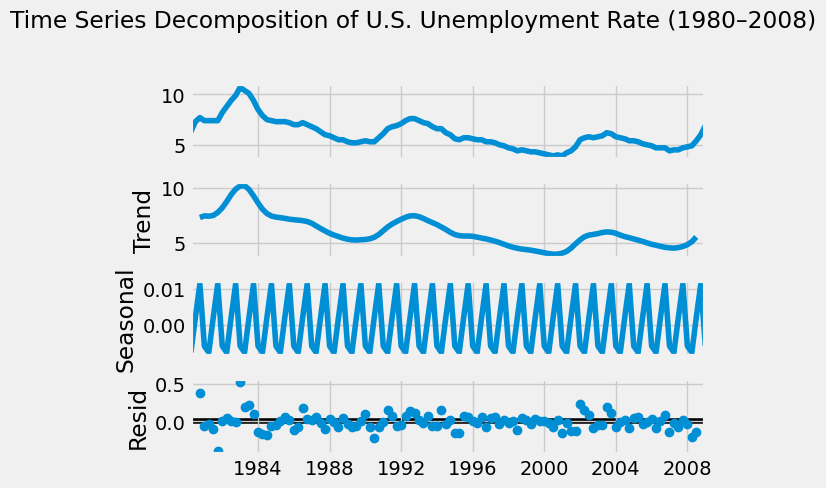

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series (quarterly frequency = 4)
decomposition = seasonal_decompose(ts_data_sub, model='additive', period=4)
decomposition.plot()
plt.suptitle('Time Series Decomposition of U.S. Unemployment Rate (1980–2008)', y=1.02)
plt.tight_layout()
plt.show()

Analysis of Decomposition Results:

Trend: The trend component shows a clear long-term decrease in the unemployment rate from around 1983 to the early 2000s, with some periods of increase (e.g., early 1980s and early 2000s).

Seasonality: There are recurring small fluctuations within each year, which suggests a mild but visible seasonal effect—perhaps tied to economic or labor cycles across quarters.

Residual: The residual (noise) component is relatively small, except for a few quarters where sudden spikes or dips occur. This indicates that most of the variance in the original data can be explained by the trend and seasonality components.

Overall, this decomposition confirms the presence of both trend and seasonality, suggesting that the original series is non-stationary, which must be addressed before forecasting.

Dickey-Fuller Test for Stationarity

In [51]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the original (non-differenced) unemployment data
adf_result = adfuller(ts_data_sub['unemp'])

# Print the test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.476555779914893
p-value: 0.12128325245536187
Critical Values:
   1%: -3.489057523907491
   5%: -2.887246327182993
   10%: -2.5804808802708528


Dickey-Fuller Test: Stationarity Check

The Augmented Dickey-Fuller (ADF) test checks whether a time series is stationary.

Null Hypothesis (H₀): The data has a unit root (i.e., it is non-stationary)

Alternative Hypothesis (H₁): The data is stationary

Test Output:

- ADF Statistic: -2.48
- p-value: 0.121
- Critical Value at 5% significance: -2.89

Interpretation:

Since the ADF statistic (-2.48) is greater than the 5% critical value (-2.89), we fail to reject the null hypothesis.

The p-value (0.121) is greater than 0.05, indicating the result is not statistically significant.

Conclusion: The data is non-stationary. There is evidence of a trend or seasonality that violates the assumptions required for forecasting. Therefore, I will proceed with differencing the data to attempt to achieve stationarity.

Apply First Differencing

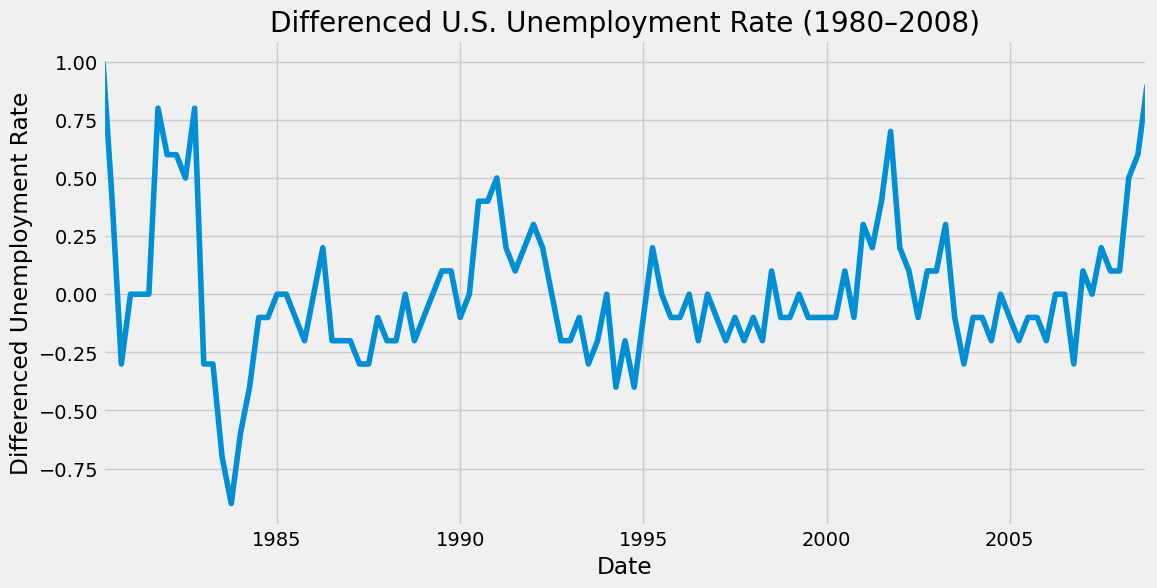

In [55]:
# Apply first differencing to remove trend
ts_data_diff = ts_data_sub.diff().dropna()

# Plot the differenced series
ts_data_diff.plot(figsize=(12, 6), title='Differenced U.S. Unemployment Rate (1980–2008)', legend=False)
plt.ylabel('Differenced Unemployment Rate')
plt.xlabel('Date')
plt.grid(True)
plt.show()

First Differencing
Since the original series was non-stationary, I applied first-order differencing, which involves subtracting each data point from its previous value. This removes the long-term trend and stabilizes the mean of the series.

The plot above shows the differenced unemployment rate. Visually, the trend appears to have been removed, and the series looks more stable.

Dickey-Fuller Test After Differencing

In [59]:
from statsmodels.tsa.stattools import adfuller

# Run ADF test on the differenced series
adf_result_diff = adfuller(ts_data_diff['unemp'])

# Print the test results
print('ADF Statistic (Differenced):', adf_result_diff[0])
print('p-value:', adf_result_diff[1])
print('Critical Values:')
for key, value in adf_result_diff[4].items():
    print(f'   {key}: {value}')

ADF Statistic (Differenced): -5.0132976197221035
p-value: 2.0886868458377074e-05
Critical Values:
   1%: -3.489057523907491
   5%: -2.887246327182993
   10%: -2.5804808802708528


Interpretation:

ADF Test After Differencing:
- ADF Statistic: -5.013
- p-value: 0.00002
- 5% Critical Value: -2.887

Interpretation:
- The ADF statistic (-5.013) is much lower than all critical values at 1%, 5%, and 10% levels.
- The p-value (0.00002) is well below 0.05, indicating the result is statistically significant.

Conclusion:
After differencing, we can reject the null hypothesis that the series has a unit root. This means the differenced unemployment rate series is now stationary.

The data is now ready for further time series modeling, such as autocorrelation analysis or forecasting.

Autocorrelation Plot

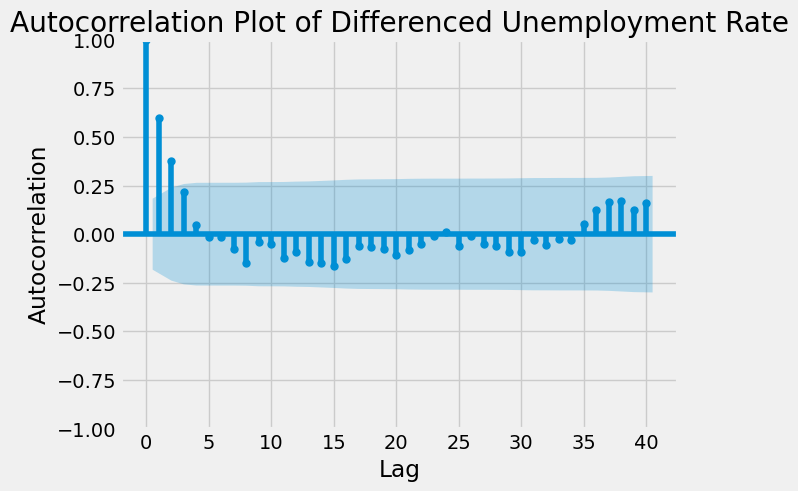

In [66]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the differenced (stationary) series
plot_acf(ts_data_diff['unemp'], lags=40)
plt.title('Autocorrelation Plot of Differenced Unemployment Rate')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

In [68]:
from statsmodels.tsa.stattools import acf

# Calculate autocorrelations for the first 40 lags
acf_values = acf(ts_data_diff['unemp'], nlags=40)

# Display the autocorrelations in a DataFrame
acf_df = pd.DataFrame({
    'Lag': range(len(acf_values)),
    'Autocorrelation': acf_values
})

acf_df.head(10)  # View first 10 lags

,Lag,Autocorrelation
0,0,1.000000
1,1,0.595153
2,2,0.377654
3,3,0.217325
4,4,0.048454
5,5,-0.015670
6,6,-0.016517
7,7,-0.076521
8,8,-0.148842
9,9,-0.042062


Autocorrelation Analysis
The Autocorrelation Function (ACF) plot shows how strongly current values in the time series are correlated with past values (lags).

The x-axis represents the number of lags (previous quarters), and the y-axis represents the correlation coefficient.

The blue shaded area is the confidence interval. If a bar extends beyond this area, it is statistically significant (i.e., that lag is autocorrelated).

Interpretation:
- Most lags fall within or near the confidence bounds, meaning that strong autocorrelation has been largely removed.
- Lag 1 shows a moderately strong autocorrelation (0.595), and lag 2 also shows some influence (0.378), which is typical for economic time series.
- Lags beyond that drop off quickly, indicating no long-term serial dependence.

This supports the earlier finding that the differenced series is now stationary.

Conclusion: The differenced data is ready for modeling or forecasting.